# Practical Session 4 - Deep Learning with PyTorch
In this session we will start with our toy task again.
Remember how we solved it with an MLP in the first class ?
We used scikit-learn, a one liner but without control over what was happening.

We will start by implementing the model in Pytorch, in a basic way.

Then we will work our way to making our code looks like a real Pytorch code.

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

np.random.seed(20)


def base_function():
    f = lambda x: 1.3 * x ** 3 - 3 * x ** 2 + 3.6 * x + 6.9
    return f

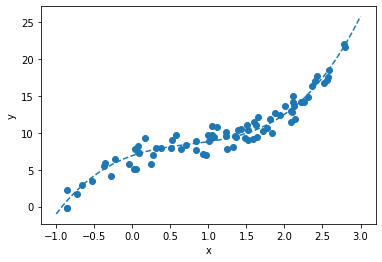

In [116]:

low, high = -1, 3
n_points = 80

# Get the values
bfunc = base_function()
xs = np.random.uniform(low, high, n_points)
sample_ys = bfunc(xs)
ys_noise = np.random.normal(size=len(xs))
noisy_sample_ys = sample_ys + ys_noise

# Plot the hidden function
lsp = np.linspace(low, high)
true_ys = bfunc(lsp)
plt.plot(lsp, true_ys, linestyle='dashed')

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We used the following command to fit the regressor last time :
"from sklearn.neural_network import MLPRegressor
 mlp_model = MLPRegressor(max_iter=5000)"

By default, the MLP Regressor makes the following computational graph :
- input gets multiplied by a matrix with 100 parameters, and an additional parameter is added to each values, giving 100 outputs y (shape = (n_samples, 100))
- ReLU is applied to each of these outputs (shape = (n_samples, 100)). The relu function is implemented in PyTorch with torch.nn.functional.relu(x)
- Then this value is multiplied by a matrix to produce a scalar output (again 100 parameters) (shape = (n_samples, 1)) and shifted by an offset.

A quick reminder on matrix multiplication : it is an operation that combines one matrix A of shape (m,n) and a matrix B of shape (n,p) into a matrix C of shape (m,p). In PyTorch (and NumPy), you need to call torch.matmul(A,B) to make this computation.

To make the two big multiplications, we will use one torch tensor of 100 parameters for each multiplication, with the appropriate shape.Create random starting tensors of parameters.

Then implement the asked computation to produce our output from our input. You should debug the operations by ensuring the shapes are correct.


In [117]:
# First create the parameters with small random initial values.
# We need to mention that we want to compute a gradient
# I provide you with the example for the first one :
w1 = torch.normal(mean=0., std=0.1, size=(1, 100), requires_grad=True)
b1 = torch.normal(mean=0., std=0.1, size=(1,), requires_grad=True)
w2 = torch.normal(mean=0., std=0.1, size=(100, 1), requires_grad=True)
b2 = torch.normal(mean=0., std=0.1, size=(1,), requires_grad=True)

In [118]:
# Then define the function
def f(x, weight1=w1, bias1=b1, weight2=w2, bias2=b2):
    y1 = torch.matmul(x, weight1) + bias1
    a1 = torch.nn.functional.relu(y1)
    out = torch.matmul(a1, weight2) + bias2
    return out


# Just to be sure everything runs, we make an inference on one input
sample_input = torch.ones(size=(1,))
f(sample_input).shape

torch.Size([1])

Now we will mostly use last class optimization procedure to train our network using Pytorch



In [119]:
# Also set up the data
# Check that when doing inference on the data, we get an output tensor of shape (80,1).
# Call us if it is not the case, there is something ~ subtle and not interesting
torch_xs = torch.from_numpy(xs).float()[:, None]
torch_noisy_ys = torch.from_numpy(noisy_sample_ys)[:, None]
f(torch_xs).shape

torch.Size([80, 1])

In [120]:
# Now like last time, let us define an optimizer and give the parameters to it.
n_iter = 2000
opt = torch.optim.Adam([w1, b1, w2, b2], lr=0.01)

In [121]:
# Loop over the data, make the forward, backward, step and zero grad
for i in range(n_iter):
    prediction = f(torch_xs, w1, b1, w2, b2)
    loss = torch.mean((prediction - torch_noisy_ys) ** 2)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if not i % 10:
        print(i, loss.item())

0 128.43667777653522
10 68.12167658962085
20 6.690158956321376
30 10.50306358754553
40 3.134505362676049
50 3.6354522967544263
60 2.980666531788375
70 2.8732974917171084
80 2.8638047910947817
90 2.8035664632056325
100 2.783276673338631
110 2.766159368667925
120 2.7472975928650043
130 2.7296354807311287
140 2.7129995441452155
150 2.696959975682973
160 2.681774791099832
170 2.666131932849785
180 2.6497479162291198
190 2.6336963455773925
200 2.617368445783595
210 2.6004877830336555
220 2.584116459848662
230 2.5669638023873818
240 2.5478843227175063
250 2.5260372710509422
260 2.500478840671688
270 2.470838674127726
280 2.438364084447726
290 2.4045284339213984
300 2.370490439888011
310 2.337166324210157
320 2.3053845134429176
330 2.2758252243324124
340 2.248729294383608
350 2.2239706717601395
360 2.2013533975403523
370 2.1805171609132565
380 2.1610453725305567
390 2.142584280779783
400 2.124909874560971
410 2.107870132160181
420 2.091426795289679
430 2.0755645145492196
440 2.060221604125945

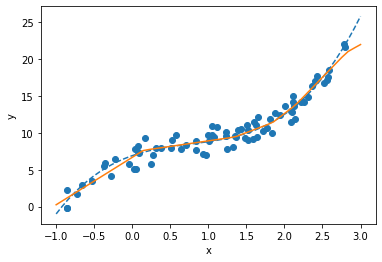

In [131]:
torch_lsp = torch.from_numpy(lsp).float()[:, None]
predicted_ys = f(torch_lsp).detach().numpy()

plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Congratulations, you have coded yourself a MLP model ! We have used the computation graph framework.


Now let us make our code prettier (more Pytorch) and more efficient.
First let us refactor the model in the proper way it should be coded, by using the torch.nn.Module class.
You should add almost no new code, just reorganize the one above into a class.

In [123]:
from torch.nn import Module, Parameter


class MyOwnMLP(Module):
    def __init__(self):
        super(MyOwnMLP, self).__init__()
        self.w1 = Parameter(torch.normal(mean=0., std=0.1, size=(1, 100)))
        self.b1 = Parameter(torch.normal(mean=0., std=0.1, size=(1,)))
        self.w2 = Parameter(torch.normal(mean=0., std=0.1, size=(100, 1)))
        self.b2 = Parameter(torch.normal(mean=0., std=0.1, size=(1,)))

    def forward(self, x):
        y1 = torch.matmul(x, self.w1) + self.b1
        a1 = torch.nn.functional.relu(y1)
        out = torch.matmul(a1, self.w2) + self.b2
        return out


model = MyOwnMLP()
out = model(torch_xs)
out.shape

torch.Size([80, 1])

Now we are good to also make the data iteration process look like Pytorch code !

We need to define a Dataset object. Once we have this, we can use it to create a DataLoader object

In [124]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        return x, y

In [125]:
# Loop and wait for each data point in PyTorch
dataset = CustomDataset(data_x=torch_xs, data_y=torch_noisy_ys)
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=6)
start = time.time()
for point in dataloader:
    pass
print('Done in pytorch : ', time.time() - start)

Done in pytorch :  0.0543065071105957


The last thing missing to make our pipeline truly Pytorch is to use a GPU.

In Pytorch it is really easy, you just need to 'move' your tensors to a 'device'.
You can test if a gpu is available and create the appropriate device with the following lines:

In [128]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
torch_xs = torch_xs.to(device)

Now we finally have all the elements to make an actual Pytorch complete pipeline !

Create a model, and try to put it on a device.
Create an optimizer with your model's parameters
Make your data into a dataloader

Then use two nested for loops : one for 100 epochs, and in each epoch loop over the dataloader
    Inside the loop, for every batch first put the data on the device
    Then use the semantics of above :
        - model(batch)
        - loss computation and backward
        - gradient step and zero_grad

In [129]:
n_epochs = 200
model = MyOwnMLP()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

dataset = CustomDataset(data_x=torch_xs, data_y=torch_noisy_ys)
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=6)

loss = 0
for epoch in range(n_epochs):
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        prediction = model(batch_x)
        loss = torch.mean((prediction - batch_y) ** 2)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss = loss.item()
    if not epoch % 10:
        print(epoch, loss)

# To easily use the trained model we need to send it back to cpu at the end
model = model.to('cpu')

0 115.58181236370794
10 4.876030560147656
20 4.623135580303074
30 4.414736199352729
40 4.254505303410427
50 4.118651449373032
60 3.977240491452485
70 3.853051635376525
80 3.6870414362462904
90 3.5334030363789237
100 3.3648277025990483
110 3.2131317566491235
120 3.0696570568643717
130 2.8775151493583775
140 2.743688015336937
150 2.624270677580293
160 2.508799282552414
170 2.4268398561616977
180 2.379719100871229
190 2.3103285839193424


We finally can plot the last model

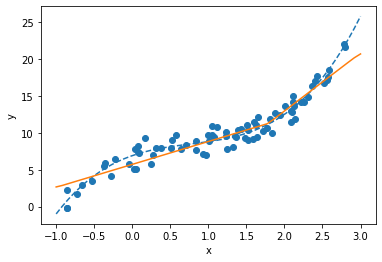

In [133]:
plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()